In [1]:

%matplotlib inline 
from IPython.display import clear_output
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import time
from scipy.stats import entropy

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from tqdm import tqdm
# import scipy
# import seaborn as sns
# from matplotlib import pyplot as plt
# import matplotlib as mpl
# import math
# import gensim
# from itertools import repeat
# import gensim.downloader
# from sklearn.metrics.pairwise import cosine_similarity
# import statsmodels.api as sm
# # from gensim.models.fasttext import load_facebook_mode
import warnings
warnings.filterwarnings('ignore')


In [2]:
import os
import openai

In [3]:
def make_ratings_mat(grouped_ratings_df):
    
    mat = np.zeros((len(np.unique(grouped_ratings_df.prompt)),71))
    for i,con in enumerate(np.unique(grouped_ratings_df.prompt)):
        ds = grouped_ratings_df[grouped_ratings_df.prompt==con]
        mat[i,:] = ds.iloc[:,3].values


    mat = pd.DataFrame(mat, index =np.unique(grouped_ratings_df.prompt), columns = np.arange(mat.shape[1]) )
    cmeans = mat.mean().values
    return mat, cmeans

In [4]:
set_1_raw = pd.read_csv('../../data/uw71_set1_redo_raw.csv')
set_2_raw = pd.read_csv('../../data/uw71_set2_raw.csv')
set_3_raw = pd.read_csv('../../data/uw71_set3_raw.csv')
set1_grouped = set_1_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
set2_grouped = set_2_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
set3_grouped = set_3_raw.groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()

ratings1,ratings_cmeans1= make_ratings_mat(set1_grouped)
ratings2,ratings_cmeans2= make_ratings_mat(set2_grouped)
ratings3,ratings_cmeans3= make_ratings_mat(set3_grouped)

concept_list = set1_grouped.pivot(index=['prompt','concept'], columns='color_index', values='mean_rating').reset_index().sort_values(by=['concept','prompt']).reset_index(drop=True)['prompt'].values
concept_list.sort()
concept_order  = {concept: i for i, concept in enumerate(concept_list)}

In [5]:
uw71coords = pd.read_csv('../../data/UW71coordinates_long.csv')

In [6]:
uw71coords

,v_index,color_index,L,a,b,C,H,r_rgb,g_rgb,b_rgb,r255,g255,b255,color_hex
0,V1,0,50,28.8910,-73.589,79.057136,291.434944,0.18536,0.431390,0.964970,47.26680,110.004450,246.067350,#2f6ef6
1,V2,1,25,53.8570,-72.280,90.138642,306.690392,0.20878,0.093277,0.677550,53.23890,23.785635,172.775250,#3518ad
2,V3,2,50,53.8570,-72.280,90.138642,306.690392,0.52107,0.343280,0.957410,132.87285,87.536400,244.139550,#8558f4
3,V4,3,50,78.8220,-70.972,106.065699,317.999859,0.71554,0.182090,0.950150,182.46270,46.432950,242.288250,#b62ef2
4,V5,4,50,2.6168,-49.931,49.999524,273.000031,0.02815,0.479950,0.800070,7.17825,122.387250,204.017850,#077acc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,V67,66,75,-28.8910,73.589,79.057136,111.434944,0.66567,0.770750,0.060920,169.74585,196.541250,15.534600,#aac510
67,V68,67,88,-28.8910,73.589,79.057136,111.434944,0.81500,0.913800,0.258170,207.82500,233.019000,65.833350,#d0e942
68,V69,68,75,-3.9252,74.897,74.999785,93.000011,0.83409,0.720190,0.066708,212.69295,183.648450,17.010540,#d5b811
69,V70,69,88,-3.9252,74.897,74.999785,93.000011,0.98973,0.860650,0.257390,252.38115,219.465750,65.634450,#fcdb42


In [7]:
### vertically stack the ratings matrices
ratings_all = pd.concat([ratings1,ratings2,ratings3])


In [8]:
### Make a long string with all the entries in uw71coords.color_hex separated by commas
all_color_string = ', '.join(uw71coords.color_hex.values)
all_color_string


'#2f6ef6, #3518ad, #8558f4, #b62ef2, #077acc, #2e3086, #746bca, #600b84, #a553c8, #cd26c7, #4dc7e8, #1c3d61, #5e78a1, #a0bae6, #512d5f, #90689f, #d5a9e4, #72005e, #b8509e, #db1f9d, #39f6e0, #3b8378, #7ec6ba, #a2eade, #000000, #3b3b3b, #777777, #b9b9b9, #ffffff, #dddddd, #5e2b3a, #a06776, #e6a8b7, #c34f74, #e31b73, #4bcf8e, #73f5b0, #184415, #55824d, #96c58c, #baeaaf, #443b14, #83764c, #c7b88b, #eddcad, #632b14, #a8664b, #f1a78a, #c94e4b, #e81a4b, #0e8a19, #67cf5c, #8cf47e, #608218, #a3c55b, #c8e97d, #897618, #d0b85a, #f7db7c, #ac6619, #f7a75a, #cc4f1b, #ea1d1d, #3efe44, #73cf10, #9af443, #aac510, #d0e942, #d5b811, #fcdb42, #fba714'

In [11]:


with open('API_key_soil.txt') as f:
    openai.api_key= f.readline()
    f.close()



assocs = np.zeros((10,71))
for i in range(10):
  clear_output()
  print(f'Evaluating:justice')

  for j,this_color in enumerate(tqdm(uw71coords.color_hex.values)):

    time.sleep(.35)
    response = openai.ChatCompletion.create(
      model="gpt-4",
      messages=[{
            "role": "system",
            "content": "You are an expert on color-concept associations."
          },

          {
            "role": "user",
            "content": f"I will give you the hexcode for a color and a concept word. Rate on a continuous scale from 0 to 1, using 3 decimal places, how associated the color is with the concept.\
            Let's do the rating task - \
    Concept: 'justice'\
    Colors: {this_color}\
    Answer with only the numbers:"
          }],
      temperature=1,
      max_tokens=10
    )
    assocs[i,j] = float(response.choices[0].message.content)
  gpt_assoc_df = pd.DataFrame(assocs, index = np.array(['justice']*10), columns = np.arange(71))
  gpt_assoc_df.to_csv('../../data/gpt4_ratings_justice.csv')


Evaluating:justice


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 53/71 [00:58<00:22,  1.23s/it]

In [11]:
all_color_string

'#2f6ef6, #3518ad, #8558f4, #b62ef2, #077acc, #2e3086, #746bca, #600b84, #a553c8, #cd26c7, #4dc7e8, #1c3d61, #5e78a1, #a0bae6, #512d5f, #90689f, #d5a9e4, #72005e, #b8509e, #db1f9d, #39f6e0, #3b8378, #7ec6ba, #a2eade, #000000, #3b3b3b, #777777, #b9b9b9, #ffffff, #dddddd, #5e2b3a, #a06776, #e6a8b7, #c34f74, #e31b73, #4bcf8e, #73f5b0, #184415, #55824d, #96c58c, #baeaaf, #443b14, #83764c, #c7b88b, #eddcad, #632b14, #a8664b, #f1a78a, #c94e4b, #e81a4b, #0e8a19, #67cf5c, #8cf47e, #608218, #a3c55b, #c8e97d, #897618, #d0b85a, #f7db7c, #ac6619, #f7a75a, #cc4f1b, #ea1d1d, #3efe44, #73cf10, #9af443, #aac510, #d0e942, #d5b811, #fcdb42, #fba714'

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 50/71 [00:54<00:25,  1.20s/it]

In [79]:

# assocs = np.zeros((70,71))
# for i,this_concept in enumerate(ratings_all.index.values):
#   if this_concept in ([
#     'above',
# 'angry',
# 'beach',
# 'below',
# 'beside',
# 'blueberry',
# 'dawn',
# 'day',
# 'disgust',
# 'dress',
# 'dusk',
# 'far',
# 'fearful',
# 'field',
# 'happy',
# 'lemon',
# 'mango',
# 'near',
# 'night',
# 'noon',
# 'ocean',
# 'pants',
# 'sad',
# 'shirt',
# 'shoes',
# 'sky',
# 'socks',
# 'strawberry',
# 'sunset',
# 'watermelon',
# 'bear',
# 'bird',
# 'blizzard',
# 'boat',
# 'car',
# 'drought',
# 'evil',
# 'fish',
# 'frog',
# 'greed',
# 'hurricane',
# 'justice',
# 'lightning',
# 'lion',
# 'love',
# 'peace',
# 'plane',
# 'sandstorm']):
#     continue
#   clear_output()
#   print(f'Evaluating:{this_concept}')

#   for j,this_color in enumerate(tqdm(uw71coords.color_hex.values)):

#     time.sleep(3)
#     response = openai.ChatCompletion.create(
#       model="gpt-4",
#       messages=[{
#             "role": "system",
#             "content": "You are an expert on color-concept associations."
#           },

#           {
#             "role": "user",
#             "content": f"I will give you the hexcode for a color a concept. Rate on a continuous scale from 0 to 1, using 3 decimal places, how associated the color is with the concept.\
#             The concept is '{this_concept}'.\
#             Before rating, here's the set of all the colors {all_color_string}. Think of which color you associate most with '{this_concept}', that color should get a rating of 1. Now think of\
#             which color you associated least with '{this_concept}', that color should get a rating of 0. Okay, now let's do the rating task.\
#     Concept: '{this_concept}'\
#     Color: {this_color}\
#     Answer with only the number:"
#           }],
#       temperature=0,
#       max_tokens=10
#     )
#     assocs[i,j] = float(response.choices[0].message.content)
#   gpt_assoc_df = pd.DataFrame(assocs, index = ratings_all.index.values, columns = np.arange(71))
#   gpt_assoc_df.to_csv('../../data/recon_assocs/gpt4_ratings_anchored_4.csv')


Evaluating:working


100%|██████████| 71/71 [04:31<00:00,  3.82s/it]


In [85]:
gpt_assoc_anchor_df = pd.read_csv('../../data/recon_assocs/gpt4_ratings_anchored_final.csv', index_col=0)
gpt_assoc_noanchor_df = pd.read_csv('../../data/recon_assocs/gpt4_ratings.csv', index_col=0)

In [180]:
assocs_justice = pd.read_csv('../../data/recon_assocs/gpt4_ratings_justice.csv')

In [184]:
gpt_cor_df[gpt_cor_df.concept=='justice']

,concept,cor_noanchor,cor_anchor,specificity
41,justice,0.27472,-0.001911,0.236187


PearsonRResult(statistic=0.26634423107667254, pvalue=0.024758933849302823)

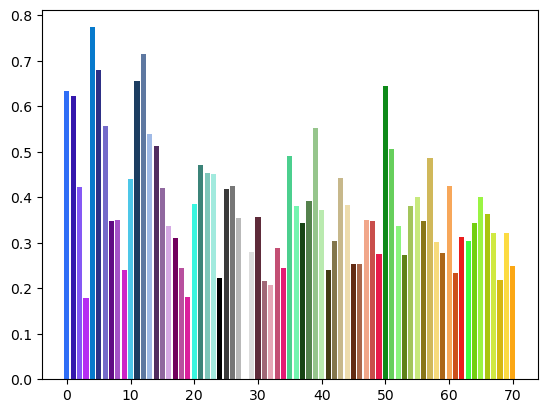

In [185]:
plt.bar(np.arange(71),assocs_justice.iloc[:3,1:].mean().values,color= uw71coords.color_hex.values)
pearsonr(assocs_justice.iloc[0:3,1:].mean().values, ratings_all[ratings_all.index=='justice'].values[0])

Text(0.5, 1.0, 'GPT4 Color-Concept Associations Anchor')

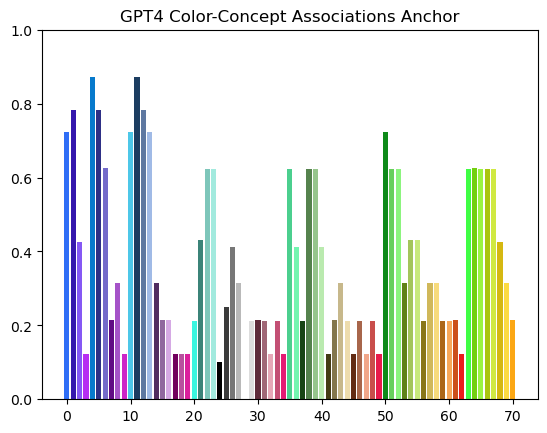

In [159]:
# import seaborn as sns
import matplotlib.pyplot as plt
### make the barplot of assocs and color each bar with the 71 colors in uw71coords.color_hex.values
plt.bar(np.arange(71),gpt_assoc_anchor_df[gpt_assoc_anchor_df.index=='justice'].values[0], color = uw71coords.color_hex.values)
plt.ylim([0,1])
plt.title('GPT4 Color-Concept Associations Anchor')

Text(0.5, 1.0, 'GPT4 Color-Concept Associations No Anchor')

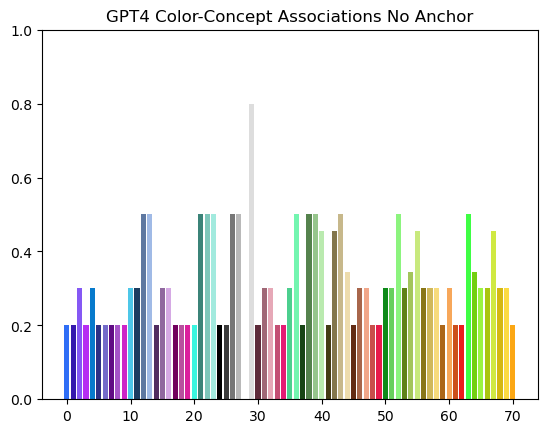

In [110]:
plt.bar(np.arange(71),gpt_assoc_noanchor_df[gpt_assoc_noanchor_df.index=='near'].values[0], color = uw71coords.color_hex.values)
plt.ylim([0,1])
plt.title('GPT4 Color-Concept Associations No Anchor')

Text(0, 0.5, 'No Anchor')

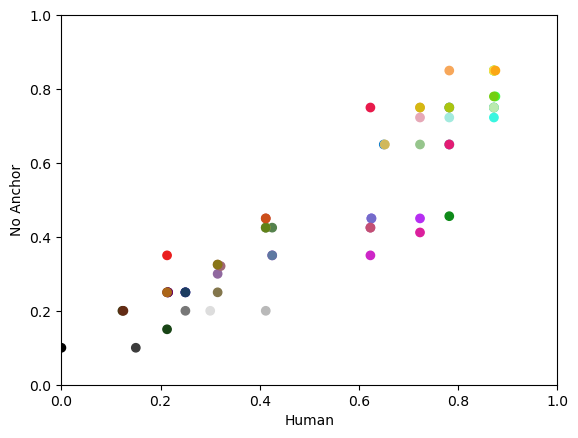

In [130]:
plt.scatter(gpt_assoc_anchor_df[ratings_all.index=='happy'].values[0],gpt_assoc_noanchor_df[gpt_assoc_noanchor_df.index=='happy'].values[0], color = uw71coords.color_hex.values)
plt.ylim([0,1])
plt.xlim([0,1])
plt.xlabel('Human')
plt.ylabel('No Anchor')

Text(0.5, 1.0, 'Human Color-Concept Associations')

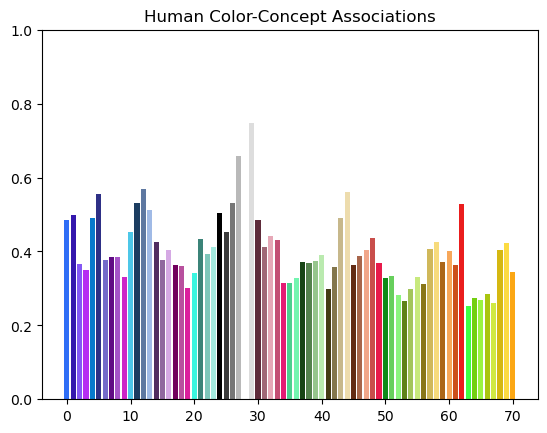

In [166]:
plt.bar(np.arange(71),ratings_all[ratings_all.index=='justice'].values[0], color = uw71coords.color_hex.values)
plt.ylim([0,1])
plt.title('Human Color-Concept Associations')

In [88]:
pearsonr(gpt_assoc_df[gpt_assoc_df.index=='greed'].values[0],ratings_all[ratings_all.index=='greed'].values[0])

PearsonRResult(statistic=nan, pvalue=nan)

In [91]:
cons =[]
cors_noanchor = []
cors_anchor = []
spec=[]
for this_concept in gpt_assoc_df.index:
    cons.append(this_concept)
    cors_noanchor.append(pearsonr(gpt_assoc_noanchor_df[gpt_assoc_noanchor_df.index==this_concept].values[0],ratings_all[ratings_all.index==this_concept].values[0])[0])
    cors_anchor.append(pearsonr(gpt_assoc_anchor_df[gpt_assoc_anchor_df.index==this_concept].values[0],ratings_all[ratings_all.index==this_concept].values[0])[0])
    
    spec.append(1/entropy(ratings_all[ratings_all.index==this_concept].values[0]))
gpt_cor_df = pd.DataFrame({'concept':cons,'cor_noanchor':cors_noanchor,'cor_anchor': cors_anchor,'specificity':spec})


mean correlation: 0.7369424369636552


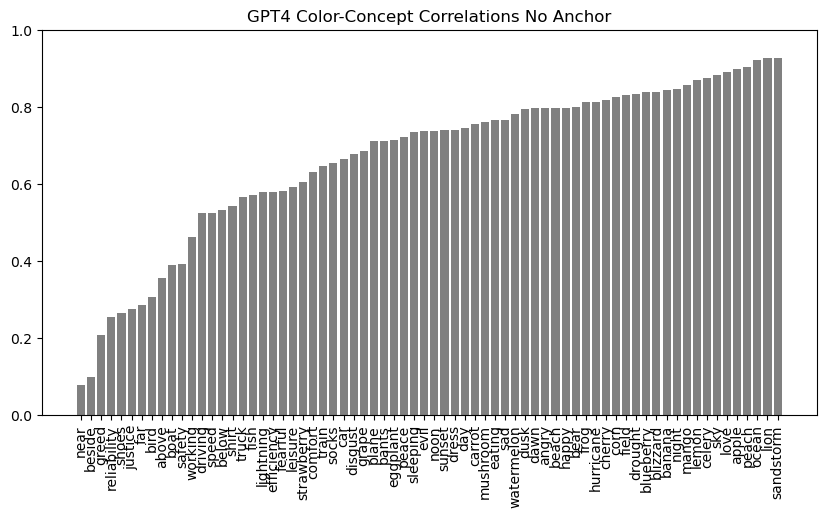

In [113]:
### sort gpt_cor_df by the correlation values and plot them as a barplot
plt.figure(figsize=(10,5))
gpt_cor_df.sort_values(by='cor_noanchor', inplace=True)
plt.bar(np.arange(70),gpt_cor_df.cor_noanchor.values, color='grey')
plt.ylim(0,1)
plt.xticks(np.arange(70),gpt_cor_df.concept.values, rotation=90)
plt.title('GPT4 Color-Concept Correlations No Anchor')
print('mean correlation:',gpt_cor_df.cor_noanchor.median())

mean correlation: 0.6909520402354874


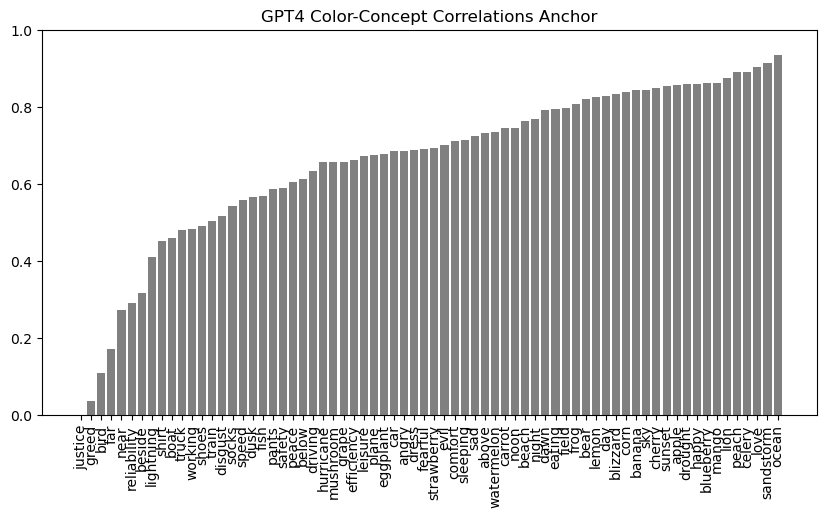

In [112]:
### sort gpt_cor_df by the correlation values and plot them as a barplot
plt.figure(figsize=(10,5))
gpt_cor_df.sort_values(by='cor_anchor', inplace=True)
plt.bar(np.arange(70),gpt_cor_df.cor_anchor.values, color='grey')
plt.ylim(0,1)
plt.xticks(np.arange(70),gpt_cor_df.concept.values, rotation=90)
plt.title('GPT4 Color-Concept Correlations Anchor')
print('mean correlation:',gpt_cor_df.cor_anchor.median())

Text(0.5, 1.0, 'GPT4 Color-Concept Correlations Anchor & No Anchor')

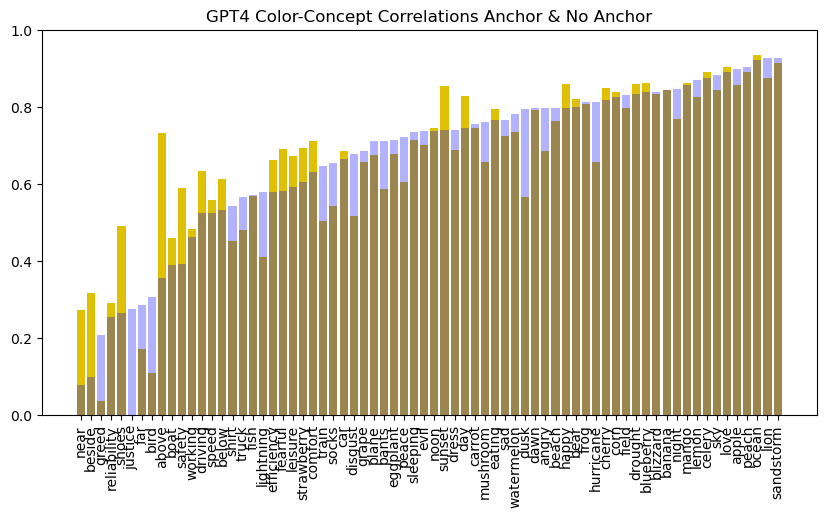

In [145]:
gpt_cor_df

## plot gpt_cor_df.cor_noanchor and gpt_cor_df.cor_anchor as overlapping barplots. make the bars transparent
gpt_cor_df = gpt_cor_df.sort_values(by='cor_noanchor', ascending=True)
plt.figure(figsize=(10,5))
# gpt_cor_df.sort_values(by='cor_anchor', inplace=True)
plt.bar(np.arange(70),gpt_cor_df.cor_anchor.values, color='#dec104', alpha=1)
plt.bar(np.arange(70),gpt_cor_df.cor_noanchor.values, color='blue', alpha=.3)




plt.ylim(0,1)
plt.xticks(np.arange(70),gpt_cor_df.concept.values, rotation=90)
plt.title('GPT4 Color-Concept Correlations Anchor & No Anchor')


In [96]:
### split half cors


g1_subs = np.random.choice(set_1_raw[set_1_raw.prompt=='happy'].subject_id, 25, replace=False)
g2_subs = np.setdiff1d(set_1_raw[set_1_raw.prompt=='happy'].subject_id, g1_subs)
g1_grouped = set_1_raw[set_1_raw.subject_id.isin(g1_subs)].groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
g2_grouped = set_1_raw[set_1_raw.subject_id.isin(g2_subs)].groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
g1_ratings = make_ratings_mat(g1_grouped)[0]
g2_ratings = make_ratings_mat(g2_grouped)[0]

g1_happy = g1_ratings[g1_ratings.index=='happy']
g2_happy = g2_ratings[g2_ratings.index=='happy']

## compute the correlation between g1_happy and g2_happy with the spearman brown correction
corrected_sh = 2*pearsonr(g1_happy.values[0],g2_happy.values[0])[0]/(1+pearsonr(g1_happy.values[0],g2_happy.values[0])[0])
corrected_sh

0.9785009768890496

In [97]:
all_raw = pd.concat([set_1_raw,set_2_raw,set_3_raw])
corrected_shs = []
con=[]
for i in range(30):
    for this_concept in ratings_all.index:
        this_concept_ratings = all_raw[all_raw.prompt==this_concept]
        sub_1 = np.random.choice(this_concept_ratings.subject_id.unique(), int(this_concept_ratings.subject_id.nunique()/2), replace=False)
        sub_2 = np.setdiff1d(this_concept_ratings.subject_id, sub_1)
        g1_grouped = this_concept_ratings[this_concept_ratings.subject_id.isin(sub_1)].groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
        g2_grouped = this_concept_ratings[this_concept_ratings.subject_id.isin(sub_2)].groupby(['concept','prompt','color_index']).response.agg(mean_rating = 'mean', se ='sem').reset_index()
        g1_ratings = make_ratings_mat(g1_grouped)[0]
        g2_ratings = make_ratings_mat(g2_grouped)[0]
        con.append(this_concept)
        corrected_shs.append(2*pearsonr(g1_ratings.values[0],g2_ratings.values[0])[0]/(1+pearsonr(g1_ratings.values[0],g2_ratings.values[0])[0]))



In [98]:
sh_df = pd.DataFrame({'concept':con,'sh':corrected_shs})
mean_sh_df = sh_df.groupby('concept').sh.agg(mean_sh='mean').reset_index()
mean_sh_df=mean_sh_df.sort_values(by='mean_sh', ascending=True)
concept_order = {concept: i for i, concept in enumerate(mean_sh_df.sort_values(by='mean_sh', ascending=True).concept.values)}

Text(0.5, 1.0, 'Human Color-Concept Split Half Correlations')

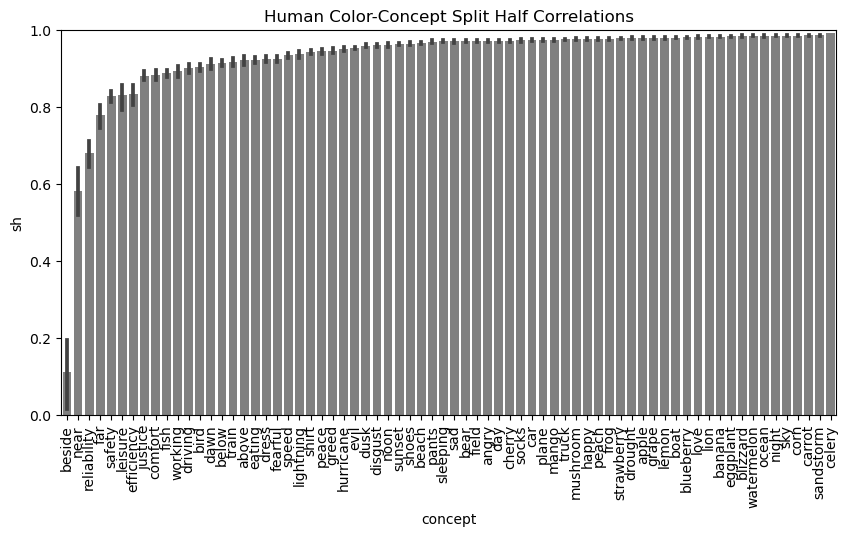

In [99]:
import seaborn as sns
plt.figure(figsize=(10,5))
### sort sh_df by concept and do it in the order of the concept_order dictionary
sh_df['order'] = sh_df.concept.map(concept_order)
sh_df.sort_values(by='order', inplace=True)



sns.barplot(x='concept', y='sh',data=sh_df, color='grey')
plt.ylim(0,1)
### rotate the xticks by 90 degrees
plt.xticks(rotation=90)
plt.title('Human Color-Concept Split Half Correlations')

In [ ]:
spearmanr(mean_sh_df.concept.values, gpt_cor_df.concept.values)

In [ ]:
pearsonr(mean_sh_df.sort_values(by='concept').mean_sh.values, gpt_cor_df.sort_values(by='concept').cor.values)

In [ ]:
gpt_cor_df.sort_values(by='concept',inplace=True)
mean_sh_df.sort_values(by='concept',inplace=True)
gpt_cor_df['cor'] = gpt_cor_df.cor/mean_sh_df.mean_sh

In [ ]:
plt.figure(figsize=(10,5))
gpt_cor_df.sort_values(by='cor', inplace=True)
plt.bar(np.arange(70),gpt_cor_df.cor.values, color='grey')
plt.ylim(0,1)
plt.xticks(np.arange(70),gpt_cor_df.concept.values, rotation=90)
plt.title('GPT4 Color-Concept Correlations')